# CS 168 Spring Assignment 7

SUNet ID(s): 05794739

Name(s): Luis A. Perez

Collaborators: None

By turning in this assignment, I agree by the Stanford honor code and declare
that all of this is my own work.


# Imports

In [114]:
import collections
import matplotlib.pyplot as plt
import scipy

import numpy as np
from PIL import Image
from sklearn import decomposition
import pandas as pd
import seaborn as sns
import os
import warnings

import IPython

from typing import Dict, List, Text, Tuple

# Make figure larger
plt.rcParams['figure.figsize'] = [10, 5]

# Set numpy seed for consistent results.
np.random.seed(1)

In [2]:
class Globals:
    DATA_PATH = 'data/'

# Part 1

## Part 1b

In [105]:
def circle_graph(n=10):
    """Returns transition matrix for a circle graph."""
    A = np.zeros((n, n))
    for i in range(n):
        A[i, (i + 1) % n] = 1
        A[(i + 1) % n, i] = 1
    return 0.5 * A, 1 / n * np.ones((1, n))

def circle_graph_with_extra_edge(n=10, a=1, b=5):
    """Same as above but for a circle graph with an additional edge (a,b)."""
    P, _ = circle_graph(n=n)
    P[a-1, b-1] = 0.5
    P[b-1, a-1] = 0.5
    P[a-1, :] = P[a-1, :] * 2 / 3
    P[b-1, :] = P[b-1, :] * 2 / 3
    denom = 2*(n-2) + 3*2
    pi = 2 * np.ones((1, n)) / denom
    pi[0, a - 1] = 3 / denom
    pi[0, b - 1] = 3 / denom
    
    return P, pi

In [ ]:
def variation_distance(x, y):
    return 1 / 2 * np.sum(np.abs(x - y))

def chain_mixing(T, pi):
    s = np.zeros((1, np.shape(T)[0]))
    s[0, 0] = 1
    distance = [variation_distance(s, pi)]
    for t in range(1, 101):
        s = np.dot(s, T)
        distance.append(variation_distance(s, pi))
        
    return distance

In [110]:
def problem1b():
    graphs = {
        '10-circle' : circle_graph(n=10),
        '9-circle': circle_graph(n=9),
        '9-circle-with-extra-edge': circle_graph_with_extra_edge(n=9)
    }
    for name, (T, pi) in graphs.items():
        dists = chain_mixing(T, pi)
        plt.plot(range(len(dists)), dists, label=name)
    plt.legend()
    plt.title('Distribution Mixing From Initial State on Node 1')
    plt.ylabel('Variational Distance')
    plt.xlabel('Mixing Time')
    plt.savefig('figures/mixing_time.png', format='png')
    plt.close()

In [111]:
problem1b()

## Part 1c

In [136]:
def problem1c():
    graphs = {
        '10-circle' : circle_graph(n=10),
        '9-circle': circle_graph(n=9),
        '9-circle-with-extra-edge': circle_graph_with_extra_edge(n=9)
    }
    for name, (T, _) in graphs.items():
        w, _ = np.linalg.eig(T.T)
        second_max_idx = len(w) - 2
        lambda2 = np.partition(w, second_max_idx)[second_max_idx]
        print(f'{name}')
        IPython.display.display(IPython.display.Math(f'\lambda_2={lambda2}'))

In [137]:
problem1c()

10-circle


<IPython.core.display.Math object>

9-circle


<IPython.core.display.Math object>

9-circle-with-extra-edge


<IPython.core.display.Math object>

# Part 2

In [197]:
def route_length(D, idx):
    """Computes total length of route visiting the specified idx in order."""
    return sum([D[idx[i], idx[i+1]] for i in range(len(idx) - 1)])

def load_distance():
    """Loads a matrix containing all pair-wise distances between all parks."""
    data = pd.read_csv(os.path.join(Globals.DATA_PATH, 'parks.csv'))
    X = np.stack((data['Longitude'], data['Latitude'])).T
    n = np.shape(X)[0]
    X2 = np.diag(np.dot(X, X.T)).reshape((n, 1))
    Y2 = X2.reshape((1, n))
    XY = np.dot(X, X.T)
    D = np.sqrt(X2 + Y2 - 2*XY)
    park_to_idx = {name: i for i, name in enumerate(data['Name'])}
    idx_to_park = {i : name for name, i in park_to_idx.items()}
    
    # Sanity checks.
    assert np.allclose(D[park_to_idx['Acadia'], park_to_idx['Arches']], 41.75, rtol=1e-4)
    assert np.allclose(route_length(D, list(range(n)) + [0]), 491.92)
    return D, park_to_idx, idx_to_park

## Part 2a

In [216]:
def mcmc(D, n_iters, T, route_fn):
    """Implements MCMC for Eucledian Traveling Salesmen on Distance Matrix D."""
    route = np.array(range(D.shape[0]))
    np.random.shuffle(route)
    best = route.copy()
    
    selected = np.random.choice(range(D.shape[0]), replace=True, size=n_iters)
    selected2 = np.random.choice(range(D.shape[0]), replace=True, size=n_iters)
    route_dists = []
    for idx, idx2 in zip(selected, selected2):
        newroute = route.copy()
        route_fn(route, newroute, idx, idx2)
        route_dist = route_length(D, route.tolist() + [route[0]])
        newroute_dist = route_length(D, newroute.tolist() + [newroute[0]])
        route_dists.append(route_dist)
        delta_dist = newroute_dist - route_dist
        if delta_dist < 0 or (T > 0 and np.random.uniform() < np.exp(-delta_dist / T)):
            route = newroute
        if route_length(D, route.tolist() + [route[0]]) < route_length(D, best.tolist() + [best[0]]):
            best = route
    return best, route_dists

## Part 2b

In [225]:
def sequential_modify(route, newroute, idx, idx2):
    del idx2
    next_idx = (idx + 1) % D.shape[0]
    newroute[idx] = route[next_idx]
    newroute[next_idx] = route[idx]
    
def problem2b():
    D, park_to_idx, idx_to_park = load_distance()
    for T in [0, 1, 10, 100]:
        best_length = None
        for trial in range(10):
            _, y = mcmc(D, n_iters=10000, T=T, route_fn=sequential_modify)
            plt.plot(range(len(y)), y, label=f'trial_idx={trial + 1}')
            if best_length is None or min(y) < best_length:
                best_length = min(y)

        plt.legend()
        plt.title(f'Current Route by Iteration for T={T}')
        plt.xlabel('Iteration')
        plt.ylabel('Route Distance')
        plt.savefig(f'figures/route_by_iteration_t={T}.png', format='png')
        plt.close()
        
        print(f'[T={T}]The best found route over all trials was: {best_length:.2f}.')

In [226]:
problem2b()

[T=0]The best found route over all trials was: 375.42.
[T=1]The best found route over all trials was: 320.64.
[T=10]The best found route over all trials was: 279.21.
[T=100]The best found route over all trials was: 358.89.


## Problem 2c

In [231]:
def random_modify(route, newroute, idx, idx2):
    newroute[idx] = route[idx2]
    newroute[idx2] = route[idx]
    
def problem2c():
    D, park_to_idx, idx_to_park = load_distance()
    for T in [0, 1, 10, 100]:
        best_length = None
        for trial in range(10):
            _, y = mcmc(D, n_iters=10000, T=T, route_fn=random_modify)
            if best_length is None or min(y) < best_length:
                best_length = min(y)
            plt.plot(range(len(y)), y, label=f'trial_idx={trial + 1}')
        plt.legend()
        plt.title(f'Current Route by Iteration for T={T}')
        plt.xlabel('Iteration')
        plt.ylabel('Route Distance')
        plt.savefig(f'figures/route_by_iteration_t={T}_random.png', format='png')
        plt.close()
        
        print(f'[T={T}]The best found route over all trials was: {best_length:.2f}.')

In [232]:
problem2c()

[T=0]The best found route over all trials was: 200.58.
[T=1]The best found route over all trials was: 166.23.
[T=10]The best found route over all trials was: 252.79.
[T=100]The best found route over all trials was: 323.23.


# Part 3

# Part 3a

TypeError: 'MovieWriterRegistry' object is not an iterator

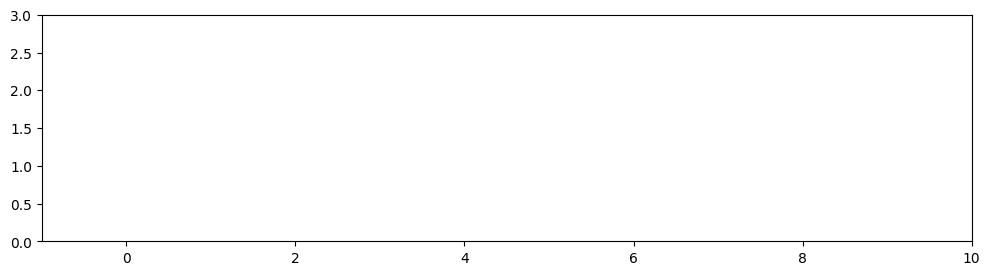

In [236]:
import qwop